In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')

# Introducción

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de regresión 

## Obtención de base de datos

In [1]:
# Se presentan las librerías utilizadas:
# Importaciones
import numpy as np
import pandas as pd
#import pandas_profiling
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import xlsxwriter
import datetime
import statsmodels.api as sm
import requests
import json
import plotly.express as px
import ydata_profiling
from matplotlib import rcParams
from numpy import mean
from numpy import std

# Para modelaje:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import VotingRegressor
from imblearn import FunctionSampler
from sklearn import metrics
%pip install ipython-autotime
%load_ext autotime
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

Note: you may need to restart the kernel to use updated packages.
time: 0 ns (started: 2023-06-24 21:52:07 -03:00)


In [2]:
#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))

time: 13.6 s (started: 2023-06-24 21:52:22 -03:00)


## Feature extraction preliminar

In [3]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Se eliminan valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Se elimninan edades fuera de estándar
df.drop(df[(df['Destino'] =='EXP')].index, inplace=True) # se eliminan crianzas de pollos enviados a exportación


time: 78 ms (started: 2023-06-24 21:52:39 -03:00)


In [4]:
columns_names = df.columns.values
columns_names

array(['granja', 'Nombre', 'Primer BB', 'Cantid. BB', 'A Faena',
       '% a 7 Días', '% Mortan.', '% Fal.', 'Kg. Pollo', 'P. Prom.',
       'Kg. Alim.', 'Conv', 'Ulto. Levan.', 'Edad', 'A.D.', 'E.F.S.',
       'Gas', '$ x Ave Ter.', 'Gas x Ave In.', 'Bonificación',
       'Total Liqu.', 'Total Liq. con Bioseguridad',
       '$ AVE FINAL POR SISTEMA', 'año ingreso', 'mes ingreso',
       'semana ingreso', 'año levante', 'mes levante', 'semana levante',
       'sexo', 'zona', 'Tipo de granja', 'Estación del año',
       'Días de receso', 'Días de receso corregido',
       'Fuera de rango por receso', 'fuera de rango por mortandad',
       'mortandad semanal promedio', 'Conversión ajustada a 2,7 kg',
       'Consumo medio diario (g)', 'Consumo ajustado a 2,7 kg', 'Destino',
       'capacidad', 'Densidad', 'kg pollo/m2', 'aves/comedero',
       'Cuartil por crianza 2017', 'Ventilación forzada',
       'Ambiente controlado', 'Distancia a planta alimento', 'localidad',
       'experim', 'da

time: 16 ms (started: 2023-06-24 21:01:35 -03:00)


In [4]:
#subset para modelo
dfm=df[['Días de receso corregido','granja','Cantid. BB','% a 7 Días','% Mortan.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','zona prod' ]]
dfm.head()

,Días de receso corregido,granja,Cantid. BB,% a 7 Días,% Mortan.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,zona prod
0,14,2544,36000,0.55,2.88,49.0,1,115.963592,verano,12.000000,S,N,San Pedro,-10.389276,Arrecifes,BA
1,12,2558,57500,0.83,5.71,52.9,1,117.081839,verano,10.454545,N,N,Salto,-14.867094,Arrecifes,BA
2,11,2761,39000,0.92,6.45,49.0,1,127.820226,verano,9.470000,N,N,Chivilcoy,-1.227077,25 de mayo,BA
3,9,2524,30000,1.35,5.90,49.0,1,127.343729,verano,10.000000,N,N,San Pedro,-1.595289,Arrecifes,BA
4,10,2741,42000,0.76,7.35,51.0,1,138.304026,verano,10.769231,N,N,Arrecifes,3.530095,Arrecifes,BA


time: 47 ms (started: 2023-06-24 21:52:46 -03:00)


In [5]:
def df_explore(dfm):
    # Tabla de descripción de las principales características de cada columna de un conjunto de datos
    print( 'Shape: ', df.shape)

    t = PrettyTable(['Variable',
                     'Tipo',
                     'Cant. No Nulos',
                     'Cant. Nulos',
                     '% Nulos',
                     'Valores Únicos',
                     'Ejemplo',
                    ])

    for c in dfm.columns:
        t.add_row([c,                                                                                         # Variable
                   dfm[c].dtype,                                                                               # tipo
                   len(dfm[c])-np.sum(dfm[c].isna().sort_values(ascending=False)),                              # Cant. No Nulos
                   np.sum(dfm[c].isna()),                                                                 # Cant. Nulos
                   np.round(dfm[c].isna().sort_values(ascending=False).sum()/len(df)*100, 2),        # % Nulos
                   np.count_nonzero(dfm[c].unique()),                                                          # Valores Únicos
                   dfm[~dfm[c].isnull()][c].iloc[0],                                                            # Ejemplo
                  ])
    print(t)
    print()
    return

df_explore(dfm)

Shape:  (14629, 66)
+--------------------------+---------+----------------+-------------+---------+----------------+---------------------+
|         Variable         |   Tipo  | Cant. No Nulos | Cant. Nulos | % Nulos | Valores Únicos |       Ejemplo       |
+--------------------------+---------+----------------+-------------+---------+----------------+---------------------+
| Días de receso corregido |  int64  |     14629      |      0      |   0.0   |       28       |          14         |
|          granja          |  int64  |     14629      |      0      |   0.0   |      753       |         2544        |
|        Cantid. BB        |  int64  |     14629      |      0      |   0.0   |      2390      |        36000        |
|        % a 7 Días        | float64 |     14629      |      0      |   0.0   |      620       |         0.55        |
|        % Mortan.         | float64 |     14629      |      0      |   0.0   |      2228      |         2.88        |
|           Edad           |

In [6]:
c = dfm.corr(numeric_only=True).abs()
s = c.unstack()
correlacion=pd.DataFrame(s)
correlacion.columns=["Correlacion"]
correlaciones_max=correlacion.query("Correlacion>0.8 & Correlacion!=1")

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(correlaciones_max)

Empty DataFrame
Columns: [Correlacion]
Index: []
time: 31 ms (started: 2023-06-24 21:53:01 -03:00)


In [7]:
c = dfm.corr(numeric_only=True).abs()
s = c.unstack()
correlacion=pd.DataFrame(s)
correlacion.columns=["Correlacion"]
correlacion=correlacion[correlacion.index.isin(['Consumo medio diario (g)'], level=0)]
correlacion.query("Correlacion>0.05 & Correlacion!=1").sort_values(by="Correlacion",ascending=False)

Correlacion
Consumo medio diario (g) % desvío consumo std         0.775343
                         mes levante                  0.184582
                         Edad                         0.170924
                         % a 7 Días                   0.100126
                         % Mortan.                    0.084959
                         Días de receso corregido     0.073382

time: 32 ms (started: 2023-06-24 21:53:04 -03:00)


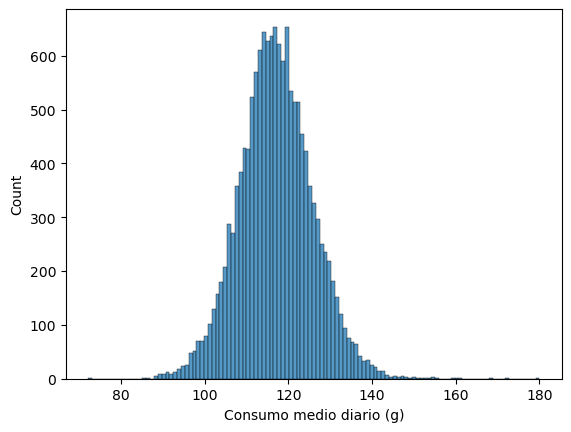

time: 594 ms (started: 2023-06-24 21:01:58 -03:00)


In [9]:
plot=sns.histplot(x="Consumo medio diario (g)", data=dfm);

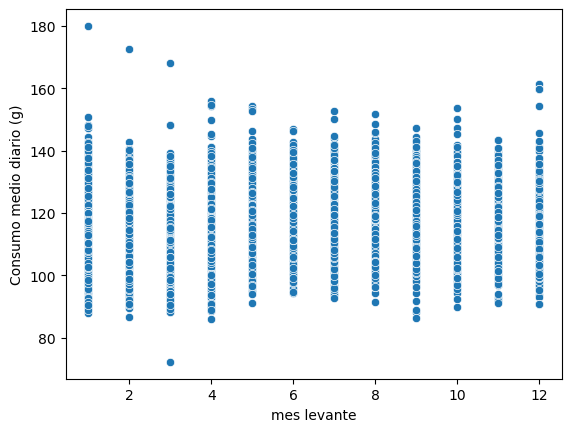

time: 204 ms (started: 2023-06-24 21:02:01 -03:00)


In [10]:
sns.scatterplot(x="mes levante",y="Consumo medio diario (g)", data=dfm);

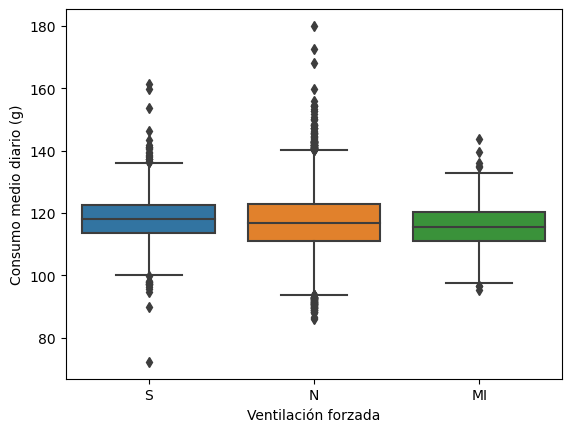

time: 157 ms (started: 2023-06-24 21:02:05 -03:00)


In [11]:
sns.boxplot(x="Ventilación forzada",y="Consumo medio diario (g)", data=dfm);

# Encoding

## Transformaciones categóricas

In [8]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['Estación del año'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['Estación del año'].values.reshape(-1, 1)).toarray()
data


array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

time: 15 ms (started: 2023-06-24 21:53:12 -03:00)


In [9]:
encoder.categories_

[array(['invierno', 'otoño', 'primavera', 'verano'], dtype=object)]

time: 0 ns (started: 2023-06-24 21:53:16 -03:00)


In [10]:
dfm = pd.concat([
    dfm.drop('Estación del año', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)

time: 0 ns (started: 2023-06-24 21:53:19 -03:00)


In [11]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['Ambiente controlado'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['Ambiente controlado'].values.reshape(-1, 1)).toarray()
data
encoder.categories_
dfm = pd.concat([
    dfm.drop('Ambiente controlado', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)


time: 31 ms (started: 2023-06-24 21:53:22 -03:00)


In [21]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['localidad'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['localidad'].values.reshape(-1, 1)).toarray()
data
encoder.categories_
dfm = pd.concat([
    dfm.drop('localidad', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)


time: 32 ms (started: 2023-06-24 21:17:09 -03:00)


In [12]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['zona climática'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['zona climática'].values.reshape(-1, 1)).toarray()
data
encoder.categories_
dfm = pd.concat([
    dfm.drop('zona climática', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)


time: 16 ms (started: 2023-06-24 21:53:30 -03:00)


In [13]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['zona prod'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['zona prod'].values.reshape(-1, 1)).toarray()
data
encoder.categories_
dfm = pd.concat([
    dfm.drop('zona prod', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)


time: 16 ms (started: 2023-06-24 21:53:33 -03:00)


In [14]:
encoder = OneHotEncoder()
data = encoder.fit_transform(dfm['Ventilación forzada'].values.reshape(-1, 1))
data
data = encoder.fit_transform(dfm['Ventilación forzada'].values.reshape(-1, 1)).toarray()
data
encoder.categories_
dfm = pd.concat([
    dfm.drop('Ventilación forzada', axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
], axis = 1)


time: 31 ms (started: 2023-06-24 21:53:35 -03:00)


In [15]:
dfm.head()

,Días de receso corregido,granja,Cantid. BB,% a 7 Días,% Mortan.,Edad,mes levante,Consumo medio diario (g),Densidad,localidad,...,otra ER,NaN,BA,CR,ER,NaN,MI,N,S,NaN
0,14.0,2544.0,36000.0,0.55,2.88,49.0,1.0,115.963592,12.000000,San Pedro,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,12.0,2558.0,57500.0,0.83,5.71,52.9,1.0,117.081839,10.454545,Salto,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11.0,2761.0,39000.0,0.92,6.45,49.0,1.0,127.820226,9.470000,Chivilcoy,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9.0,2524.0,30000.0,1.35,5.90,49.0,1.0,127.343729,10.000000,San Pedro,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10.0,2741.0,42000.0,0.76,7.35,51.0,1.0,138.304026,10.769231,Arrecifes,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


time: 32 ms (started: 2023-06-24 21:53:38 -03:00)


# Feature selection

## Exploratory Data Analysis


# Entrenamiento modelos machine learning

# Modelos de regresión con base completa

In [16]:
dfn=dfm
dfn.head()

,Días de receso corregido,granja,Cantid. BB,% a 7 Días,% Mortan.,Edad,mes levante,Consumo medio diario (g),Densidad,localidad,...,otra ER,NaN,BA,CR,ER,NaN,MI,N,S,NaN
0,14.0,2544.0,36000.0,0.55,2.88,49.0,1.0,115.963592,12.000000,San Pedro,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,12.0,2558.0,57500.0,0.83,5.71,52.9,1.0,117.081839,10.454545,Salto,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11.0,2761.0,39000.0,0.92,6.45,49.0,1.0,127.820226,9.470000,Chivilcoy,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9.0,2524.0,30000.0,1.35,5.90,49.0,1.0,127.343729,10.000000,San Pedro,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10.0,2741.0,42000.0,0.76,7.35,51.0,1.0,138.304026,10.769231,Arrecifes,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


time: 16 ms (started: 2023-06-24 21:53:42 -03:00)


In [18]:
from sklearn.model_selection import train_test_split

X3=dfn.drop('Consumo medio diario (g)', axis=1) 

y3=dfn['Consumo medio diario (g)']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=42)

time: 31 ms (started: 2023-06-24 22:09:57 -03:00)


## Linear regression

In [19]:
from sklearn.linear_model import LinearRegression


time: 0 ns (started: 2023-06-24 22:10:08 -03:00)


In [20]:
model = LinearRegression(fit_intercept=True)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)


c:\Users\ebover\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: could not convert string to float: 'San Pedro'

time: 110 ms (started: 2023-06-24 22:10:11 -03:00)


In [21]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

lr_test_mse = mean_squared_error(y3_test, y3_test_pred)
lr_train_mse = mean_squared_error(y3_train, y3_train_pred)

Error en datos de train: 1.01339441598609
Error en datos de test: 1.473659568754025


In [22]:
model.coef_

array([-3.57100378e-03, -2.77690536e-05,  4.53369695e-07, -5.26169112e-02,
       -2.03713593e-02,  2.00080018e+00,  1.57422739e-02, -9.54779886e-02,
       -4.38094655e-02, -3.45684645e-02, -5.72274659e-02,  2.82940477e-03,
        1.26159120e+00, -2.83266284e-02, -6.30676547e-02])

In [23]:
coeff_df2 = pd.DataFrame(model.coef_, X3.columns, columns=['Coefficient']).reset_index()
coeff_df2

,index,Coefficient
0,Días de receso corregido,-3.571004e-03
1,granja,-2.776905e-05
2,Cantid. BB,4.533697e-07
3,% a 7 Días,-5.261691e-02
4,% Mortan.,-2.037136e-02
5,Edad,2.000800e+00
6,mes levante,1.574227e-02
7,Estación del año,-9.547799e-02
8,Densidad,-4.380947e-02
9,Ventilación forzada,-3.456846e-02


In [24]:
ax=sns.barplot(data=coeff_df2, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-100, 40))
ax.set(title='Coeficientes de correlación');

# KNN

In [25]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X3_train, y3_train)
    scores.append(knn.score(X3_test, y3_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [26]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)



print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

knr_test_mse = mean_squared_error(y3_test, y3_test_pred)
knr_train_mse = mean_squared_error(y3_train, y3_train_pred)


Error en datos de train: 43.57636764246187
Error en datos de test: 43.18669968770842


# Random forest regression

In [27]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

In [28]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

rfr_test_mse = mean_squared_error(y3_train, y3_train_pred)
rfr_train_mse = mean_squared_error(y3_test, y3_test_pred)

Error en datos de train: 0.05508697900293476
Error en datos de test: 0.06651983056664607


# Xgboost

In [29]:
! pip install xgboost

In [30]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

In [31]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

xgb_test_mse = mean_squared_error(y3_train, y3_train_pred)
xgb_train_mse = mean_squared_error(y3_test, y3_test_pred)

Error en datos de train: 0.1754135633459414
Error en datos de test: 0.16788461475781824


In [32]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

C:\Users\ebover\AppData\Local\Temp\ipykernel_17448\2044295298.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [33]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

C:\Users\ebover\AppData\Local\Temp\ipykernel_17448\1213487991.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [34]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y3_test, y3_test_pred)
print("MSE:", mse)

MSE: 0.16788461475781824


In [35]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.40973725087892393


In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y3_test, y3_test_pred)
print("MAE:", mae)

MAE: 0.31797237295534353


In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(y3_test, y3_test_pred)
print("R^2:", r2)

R^2: 0.9978225536566645


Todos los modelos con excepción del KNN tienen valores muy bajos de MSE y elevada correlación. A continuación se realizarán pruebas con tratamientos diferentes de los datos.

## Cross validation

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# crear el modelo
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, X3, y3, cv=7, verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s finished


In [39]:
print("%0.2f de r2 promedio con una desviacion estandar de %0.2f" % (scores.mean(), scores.std()))

0.85 de r2 promedio con una desviacion estandar de 0.02


Realizando una prueba de cross validation previa a hacer correr el modelo de RandomForestRegressor el valor de correlación se redujo al 85%, por lo que disminuyó el overfitting de los modelos anteriores.

## PCA

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
X = scaler.fit_transform(X3)

In [42]:
cov_matrix = np.cov(X.T)
cov_matrix

array([[ 1.00006836e+00, -1.54238810e-01, -1.74449295e-01,
         2.49094086e-02, -6.25191174e-02, -7.69419865e-02,
         1.72668405e-01, -4.45771110e-02, -1.69428388e-01,
        -8.12870026e-02, -7.21087338e-02, -6.03990543e-02,
         1.15878089e-01,  1.18284184e-01,  1.46799656e-01],
       [-1.54238810e-01,  1.00006836e+00,  3.93559779e-01,
         1.58156618e-01, -7.87320454e-02, -5.68101786e-02,
         5.14244952e-03,  3.94739724e-03,  9.60058860e-02,
         8.63691989e-03, -1.12668627e-02,  2.37200752e-01,
         5.88729465e-02, -7.33759141e-01, -7.96449999e-01],
       [-1.74449295e-01,  3.93559779e-01,  1.00006836e+00,
         8.45504920e-02, -6.12151307e-02, -1.25482585e-01,
         1.36276038e-02, -1.11071361e-02,  4.13582770e-01,
         2.75543950e-01,  3.37505373e-01, -1.90273023e-03,
         5.75494488e-02, -4.03769050e-01, -4.53570878e-01],
       [ 2.49094086e-02,  1.58156618e-01,  8.45504920e-02,
         1.00006836e+00,  3.25959439e-01,  1.53836993

In [43]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

In [44]:
eig_vectors

array([[ 0.13727956, -0.0762289 , -0.28035897,  0.14641751, -0.33507297,
        -0.4065889 ,  0.72886758, -0.01832365,  0.02631121, -0.04623678,
         0.04716557, -0.21266307, -0.04142957,  0.11782643,  0.01588493],
       [-0.45906017,  0.2405763 , -0.10200783, -0.0463481 ,  0.09560613,
        -0.0602507 ,  0.08550543,  0.28450334,  0.74657023,  0.09314456,
         0.01755933,  0.08114654,  0.15084703,  0.14032169,  0.04927409],
       [-0.40075314, -0.09319356,  0.18285795,  0.01755454, -0.08017301,
         0.05501537,  0.05543589,  0.03382456,  0.05316579, -0.25023982,
        -0.18324632, -0.51594838, -0.22142978, -0.60645977,  0.0352411 ],
       [-0.1014172 ,  0.15896838,  0.04911929,  0.6268496 , -0.07835297,
        -0.34565228, -0.22121689,  0.04151181, -0.0192404 , -0.27475936,
         0.35397314,  0.27715591, -0.02815949, -0.1999546 , -0.2721499 ],
       [ 0.09870029,  0.22794617,  0.29110279,  0.47976149, -0.02104843,
        -0.19801903, -0.20605572, -0.02926022, 

In [45]:
eig_values

array([3.11130389, 2.31503564, 1.89231356, 1.33160683, 1.03999416,
       0.95131382, 0.83067624, 0.1411822 , 0.22960355, 0.65927642,
       0.60544616, 0.55320944, 0.41679326, 0.47252145, 0.45074882])

In [46]:
eig_values / eig_values.sum()

array([0.20740608, 0.15432516, 0.12614561, 0.08876772, 0.0693282 ,
       0.06341659, 0.05537463, 0.0094115 , 0.01530586, 0.04394876,
       0.04036032, 0.03687811, 0.02778432, 0.03149928, 0.03004787])

In [47]:
idx = eig_values.argsort()[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:, idx]

In [48]:
eig_vectors

array([[ 0.13727956, -0.0762289 , -0.28035897,  0.14641751, -0.33507297,
        -0.4065889 ,  0.72886758, -0.04623678,  0.04716557, -0.21266307,
         0.11782643,  0.01588493, -0.04142957,  0.02631121, -0.01832365],
       [-0.45906017,  0.2405763 , -0.10200783, -0.0463481 ,  0.09560613,
        -0.0602507 ,  0.08550543,  0.09314456,  0.01755933,  0.08114654,
         0.14032169,  0.04927409,  0.15084703,  0.74657023,  0.28450334],
       [-0.40075314, -0.09319356,  0.18285795,  0.01755454, -0.08017301,
         0.05501537,  0.05543589, -0.25023982, -0.18324632, -0.51594838,
        -0.60645977,  0.0352411 , -0.22142978,  0.05316579,  0.03382456],
       [-0.1014172 ,  0.15896838,  0.04911929,  0.6268496 , -0.07835297,
        -0.34565228, -0.22121689, -0.27475936,  0.35397314,  0.27715591,
        -0.1999546 , -0.2721499 , -0.02815949, -0.0192404 ,  0.04151181],
       [ 0.09870029,  0.22794617,  0.29110279,  0.47976149, -0.02104843,
        -0.19801903, -0.20605572,  0.36589584, 

In [49]:
sns.scatterplot(eig_vectors);

In [50]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_values)
var_exp = [(i / tot)*100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(15), var_exp, alpha=0.5, align='center',
            label='Varianza individual explicada', color='g')
    plt.step(range(15), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

En el gráfico se observa que los tres primeros grupos explican la mayor parte de la varianza.

In [51]:
W = eig_vectors[:, :3]
X_pca = X.dot(W)

In [52]:
data_pca = pd.DataFrame(X_pca, columns = ['PC1', 'PC2','PC3'])
data_pca = pd.concat([data_pca, y3], axis = 1)
data_pca.head()

,PC1,PC2,PC3,Consumo medio diario (g)
0,-1.943989,0.378588,1.487043,115.963592
1,-1.168620,2.519232,1.272180,117.081839
2,-1.510770,1.877993,0.043684,127.820226
3,-1.347753,1.820664,0.182468,127.343729
4,-1.405300,1.347566,0.506204,138.304026


In [53]:
data_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15743 entries, 0 to 15747
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PC1                       14629 non-null  float64
 1   PC2                       14629 non-null  float64
 2   PC3                       14629 non-null  float64
 3   Consumo medio diario (g)  14629 non-null  float64
dtypes: float64(4)
memory usage: 615.0 KB


In [54]:
data_pca.isna().sum()

PC1                         1114
PC2                         1114
PC3                         1114
Consumo medio diario (g)    1114
dtype: int64

In [55]:
data_pca=data_pca.dropna()

In [56]:
X4=data_pca.drop('Consumo medio diario (g)', 1) 

y4=data_pca['Consumo medio diario (g)']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.30, random_state=42)

C:\Users\ebover\AppData\Local\Temp\ipykernel_17448\3471747326.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X4=data_pca.drop('Consumo medio diario (g)', 1)


In [57]:
X4.isna().sum()

PC1    0
PC2    0
PC3    0
dtype: int64

In [58]:
y4.isna().sum()

0

## Linear regression

In [59]:
model = LinearRegression(fit_intercept=True)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)


In [60]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

lr_test_mse = mean_squared_error(y4_test, y4_test_pred)
lr_train_mse = mean_squared_error(y4_train, y4_train_pred)

Error en datos de train: 75.73164913469432
Error en datos de test: 75.07720896859855


In [61]:
model.coef_

array([-0.08022211,  0.17836044, -0.17317319])

In [62]:
coeff_df2 = pd.DataFrame(model.coef_, X4.columns, columns=['Coefficient']).reset_index()
coeff_df2

,index,Coefficient
0,PC1,-0.080222
1,PC2,0.178360
2,PC3,-0.173173


In [63]:
ax=sns.barplot(data=coeff_df2, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-100, 40))
ax.set(title='Coeficientes de correlación');

# KNN

In [64]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X4_train, y4_train)
    scores.append(knn.score(X4_test, y4_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [65]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=40)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)



print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

knr_test_mse = mean_squared_error(y4_test, y4_test_pred)
knr_train_mse = mean_squared_error(y4_train, y4_train_pred)


Error en datos de train: 73.05908757345728
Error en datos de test: 71.89272808984317


# Random forest regression

In [66]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)

In [67]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

rfr_test_mse = mean_squared_error(y4_train, y4_train_pred)
rfr_train_mse = mean_squared_error(y4_test, y4_test_pred)

Error en datos de train: 11.877880805256414
Error en datos de test: 11.745148024888314


# Xgboost

In [68]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)

In [69]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

xgb_test_mse = mean_squared_error(y4_train, y4_train_pred)
xgb_train_mse = mean_squared_error(y4_test, y4_test_pred)

Error en datos de train: 61.81331799300588
Error en datos de test: 60.522694959601445


In [70]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

C:\Users\ebover\AppData\Local\Temp\ipykernel_17448\2044295298.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [71]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

C:\Users\ebover\AppData\Local\Temp\ipykernel_17448\1213487991.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [72]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y4_test, y4_test_pred)
print("MSE:", mse)

MSE: 60.522694959601445


In [73]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 7.779633343519568


In [74]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y4_test, y4_test_pred)
print("MAE:", mae)

MAE: 6.044986729521293


In [75]:
from sklearn.metrics import r2_score
r2 = r2_score(y4_test, y4_test_pred)
print("R^2:", r2)

R^2: 0.19450065785654835


Luego de reducir a 3 los componentes originales de la base todos los valores de MSE resultaron elevados con excepción de RandomForest, el coeficiente de determinación, a su vez, se redujo al 20%.

## Validación del modelo

## LOOCV

In [76]:
from sklearn.model_selection import LeaveOneOut
# crear el procediemiento LOOCV
cv = LeaveOneOut()

In [77]:
LeaveOneOut

sklearn.model_selection._split.LeaveOneOut

In [78]:
# crear el modelo
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)

In [79]:
 cross_val_score

<function sklearn.model_selection._validation.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)>

In [80]:
# evaluar el modelo
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 14629 out of 14629 | elapsed: 45.1min finished


In [81]:
# evaluar el modelo (criterio de comparacion MAE)
from sklearn.metrics import mean_squared_error,  make_scorer   
MAE = make_scorer(mean_absolute_error)
scores = cross_val_score(model, X, y, scoring=MAE, cv=cv,error_score='raise',verbose=1)
# convertir a postivos
scores = abs(scores)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 14629 out of 14629 | elapsed: 76.3min finished


In [82]:
# reportar el performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

MAE: 0.000 (0.000)


El modelo se evalúa utilizando LOOCV y el rendimiento estimado al hacer predicciones sobre nuevos datos tiene una precisión de alrededor de ~%.

## Stratified- K fold

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# crear el modelo
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, X, y, cv=7, verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s finished


In [85]:
print("%0.2f de r2 promedio con una desviacion estandar de %0.2f" % (scores.mean(), scores.std()))

0.99 de r2 promedio con una desviacion estandar de 0.02


**Evaluación del modelo**:

El último paso es evaluar el rendimiento del algoritmo. Este paso es particularmente importante para comparar qué tan bien funcionan los diferentes algoritmos en un conjunto de datos en particular. Para los algoritmos de regresión, se utilizan comúnmente tres métricas de evaluación:

* El error absoluto medio (MAE)
* El error cuadrático medio (MSE)
* Root Mean Squared Error (RMSE)